# Import Library

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data

In [ ]:
# Dictionary untuk menyimpan data harga 'Close'
close_data = {}

# Mengambil data saham ASII.JK
stock_data = yf.download('ASII.JK', start="2023-09-01", end="2024-09-01")
close_data['ASII.JK'] = stock_data['Close']  # Simpan kolom 'Close' saja dengan simbol saham sebagai kunci

# Menggabungkan data 'Close' menjadi satu DataFrame
data = pd.DataFrame(close_data)

# Menampilkan data
data

[*********************100%***********************]  1 of 1 completed


,ACES.JK
Date,
2023-09-01,740.0
2023-09-04,740.0
2023-09-05,730.0
2023-09-06,725.0
2023-09-07,720.0
...,...
2024-08-26,720.0
2024-08-27,735.0
2024-08-28,730.0


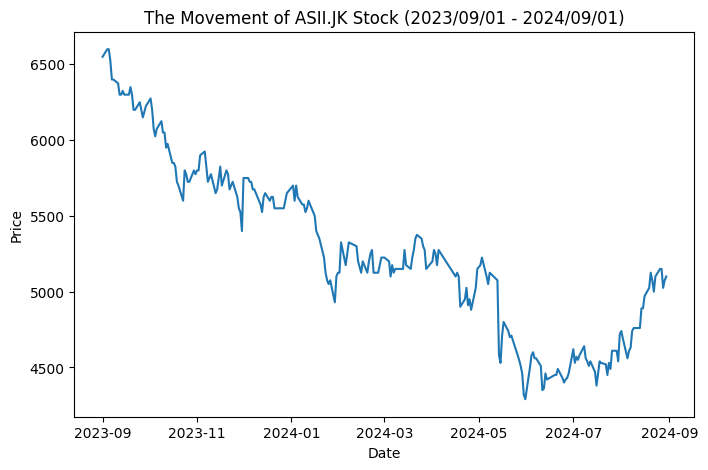

In [101]:
# Plot harga penutupan saham ASII.JK
plt.figure(figsize=(8, 5))
plt.plot(data.index, data['ASII.JK'], label='ASII.JK')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('The Movement of ASII.JK Stock (2023/09/01 - 2024/09/01)')
plt.show()


# Return Saham

In [102]:
#Menghitung log return saham
log_ret = np.log(data/data.shift(1))
log_ret.head()

,ASII.JK
Date,
2023-09-01,NaN
2023-09-04,0.007605
2023-09-05,0.000000
2023-09-06,-0.011429
2023-09-07,-0.019343


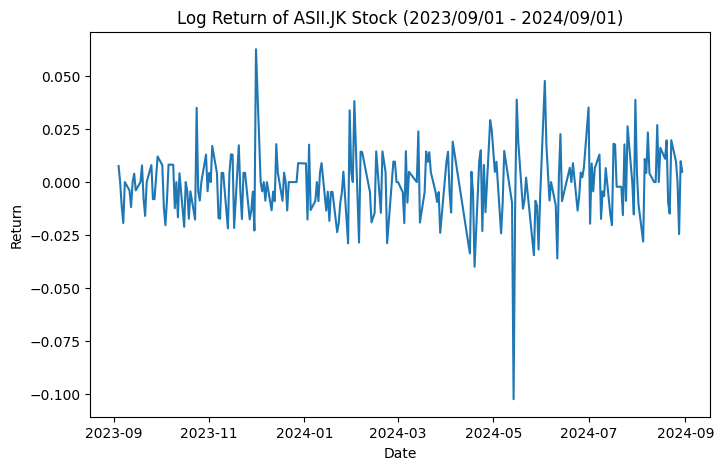

In [103]:
# Plot log return
plt.figure(figsize=(8, 5))
plt.plot(log_ret.index, log_ret['ASII.JK'], label='ASII.JK')
plt.xlabel('Date')
plt.ylabel('Return')
plt.title('Log Return of ASII.JK Stock (2023/09/01 - 2024/09/01)')
plt.show()

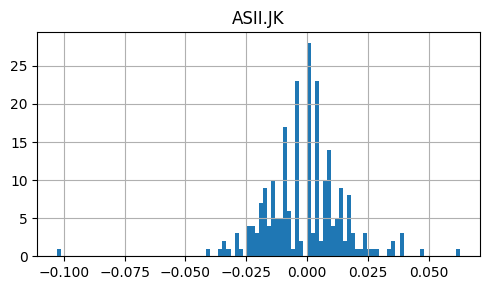

In [104]:
#Plot Distribusi log return ASII.JK
log_ret.hist(bins=100,figsize=(5,3));
plt.tight_layout()

In [105]:
log_ret.describe()

,ASII.JK
count,237.000000
mean,-0.001056
std,0.016736
min,-0.102628
25%,-0.010977
50%,0.000000
75%,0.008791
max,0.062801


# Uji Normalitas Return

In [106]:
from scipy import stats

# Melakukan uji Kolmogorov-Smirnov
stat, p_value = stats.kstest(log_ret.dropna(), 'norm', args=(np.mean(log_ret.dropna()), np.std(log_ret.dropna())))

# Menampilkan hasil
print('Kolmogorov-Smirnov Test Statistic:', stat)
print('p-value:', p_value)

Kolmogorov-Smirnov Test Statistic: [0.06178947]
p-value: [0.31303549]


c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


# VaR dan CVaR (Expected-Shortfall)

## Metode Simulasi Historis

In [122]:
log_ret_sorted = np.sort(np.array(log_ret.dropna()).flatten())

In [123]:
confidence_level = [0.90, 0.95, 0.99]
var = []
cvar = []

for i in confidence_level:
    # Menentukan VaR pada confidence level tertentu
    var_value = np.percentile(log_ret_sorted, 100 * (1 - i))
    var.append(var_value)

    # Menghitung CVaR sebagai rata-rata dari return yang lebih kecil dari VaR
    cvar_value = log_ret_sorted[log_ret_sorted <= var_value].mean()
    cvar.append(cvar_value)

df_c_var = pd.DataFrame({
    'Confidence Level': confidence_level,
    'VaR': var,
    'CVaR': cvar
})

df_c_var

,Confidence Level,VaR,CVaR
0,0.90,-0.019332,-0.029157
1,0.95,-0.024028,-0.036854
2,0.99,-0.035559,-0.059585


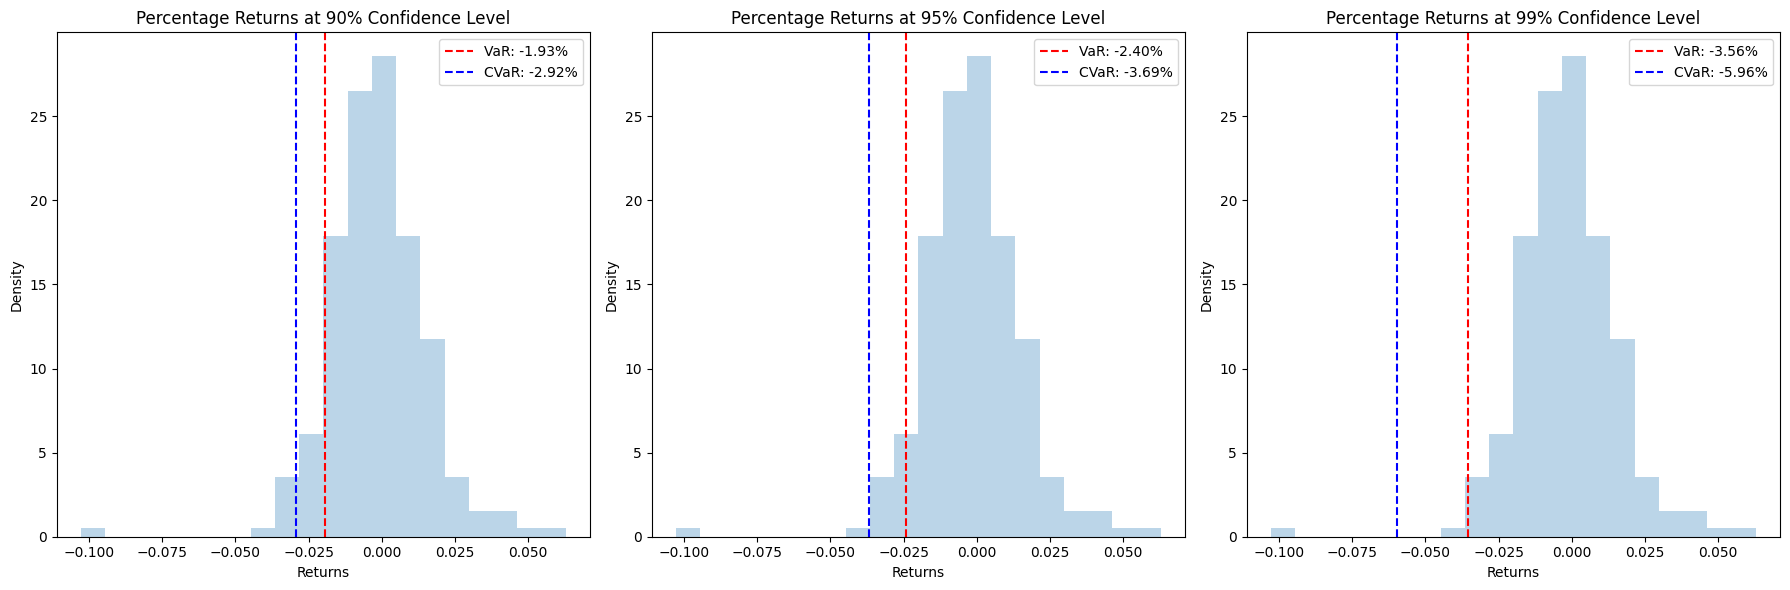

In [124]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Membuat 3 subplot dalam 1 baris

for idx, i in enumerate(confidence_level):
    ax = axes[idx]  # Pilih subplot berdasarkan indeks
    ax.hist(log_ret, bins=20, density=True, alpha=0.3)

    # Tambah VAR dan CVAR ke histogram
    ax.axvline(x=var[idx], color='red', linestyle='--', label=f"VaR: {var[idx]:.2%}")
    ax.axvline(x=cvar[idx], color='blue', linestyle='--', label=f"CVaR: {cvar[idx]:.2%}")

    ax.legend()
    ax.set_xlabel("Returns")
    ax.set_ylabel("Density")
    ax.set_title(f"Percentage Returns at {i*100:.0f}% Confidence Level")

# Optimalkan jarak antar subplot
plt.tight_layout()
plt.show()


In [125]:
import numpy as np
import pandas as pd
from scipy.stats import chi2

# Fungsi Kupiec Test
def kupiec_test(violations, total_obs, confidence_level):
    prob = 1 - confidence_level
    # Komponen LR_uc
    term_1 = -2 * ((total_obs - violations) * np.log(1 - prob) + violations * np.log(prob))
    term_2 = 2 * ((total_obs - violations) * np.log(1 - violations / total_obs) + violations * np.log(violations / total_obs))
    LR = term_1 + term_2
    chi2_critical = chi2.ppf(confidence_level, df=1)  # Nilai kritis Chi-square untuk alpha = 0.05
    return LR, chi2_critical

# Backtesting
lr_test_var = []
lr_test_cvar = []
chi_var = []
chi_cvar = []
violations_var_list = []
violations_cvar_list = []

# Perulangan berdasarkan DataFrame df_c_var
for index, row in df_c_var.iterrows():
    confidence_level = row['Confidence Level']
    var_value = row['VaR']
    cvar_value = row['CVaR']

    # Hitung jumlah pelanggaran (violations)
    violations_var = len(log_ret_sorted[log_ret_sorted <= var_value])
    violations_cvar = len(log_ret_sorted[log_ret_sorted <= cvar_value])
    total_obs = len(log_ret_sorted)

    # Simpan hasil ke dalam daftar
    violations_var_list.append(violations_var)
    violations_cvar_list.append(violations_cvar)

    # Hitung Kupiec Test untuk VaR
    lr_var, chi_var_value = kupiec_test(violations_var, total_obs, confidence_level)
    lr_test_var.append(lr_var)
    chi_var.append(chi_var_value)

    # Hitung Kupiec Test untuk CVaR
    lr_cvar, chi_cvar_value = kupiec_test(violations_cvar, total_obs, confidence_level)
    lr_test_cvar.append(lr_cvar)
    chi_cvar.append(chi_cvar_value)

# Membuat DataFrame hasil backtesting
df_backtest = pd.DataFrame({
    'Confidence Level': df_c_var['Confidence Level'],
    'VaR': df_c_var['VaR'],
    'CVaR': df_c_var['CVaR'],
    'Violations VaR': violations_var_list,
    'LR VaR': lr_test_var,
    'Chi-Square Var': chi_var,
    'Violations CVaR': violations_cvar_list,
    'LR CVaR': lr_test_cvar,
    'Chi-Square CVaR': chi_cvar
})

# Output hasil
df_backtest


,Confidence Level,VaR,CVaR,Violations VaR,LR VaR,Chi-Square Var,Violations CVaR,LR CVaR,Chi-Square CVaR
0,0.90,-0.019332,-0.029157,24,0.004204,2.705543,6,20.345168,2.705543
1,0.95,-0.024028,-0.036854,12,0.001991,3.841459,2,13.008051,3.841459
2,0.99,-0.035559,-0.059585,3,0.156027,6.634897,1,1.022204,6.634897


## Metode Variance-Covariance

In [126]:
#Membuat list kosong untuk menyimpan nilai var cvar setiap confidence level
confidence_level = [0.90, 0.95, 0.99]
var = []
cvar= []

#Menghitung parameter dari return
mu = log_ret_sorted.mean()
sigma = log_ret_sorted.std()

for i in confidence_level:
    z_score = stats.norm.ppf(1-i)
    var_value = mu - (stats.norm.ppf(i)*sigma) #Nilai Var pada confidence level tertentu
    cvar_value = mu - sigma * (stats.norm.pdf(z_score)/(1-i))  #Nilai CVaR pada confidence level tertentu
    var.append(var_value)
    cvar.append(cvar_value)

df_c_var = pd.DataFrame({
    'Confidence Level': confidence_level,
    'VaR': var,
    'CVaR': cvar
})

df_c_var

,Confidence Level,VaR,CVaR
0,0.90,-0.022458,-0.030364
1,0.95,-0.028525,-0.035503
2,0.99,-0.039906,-0.045565


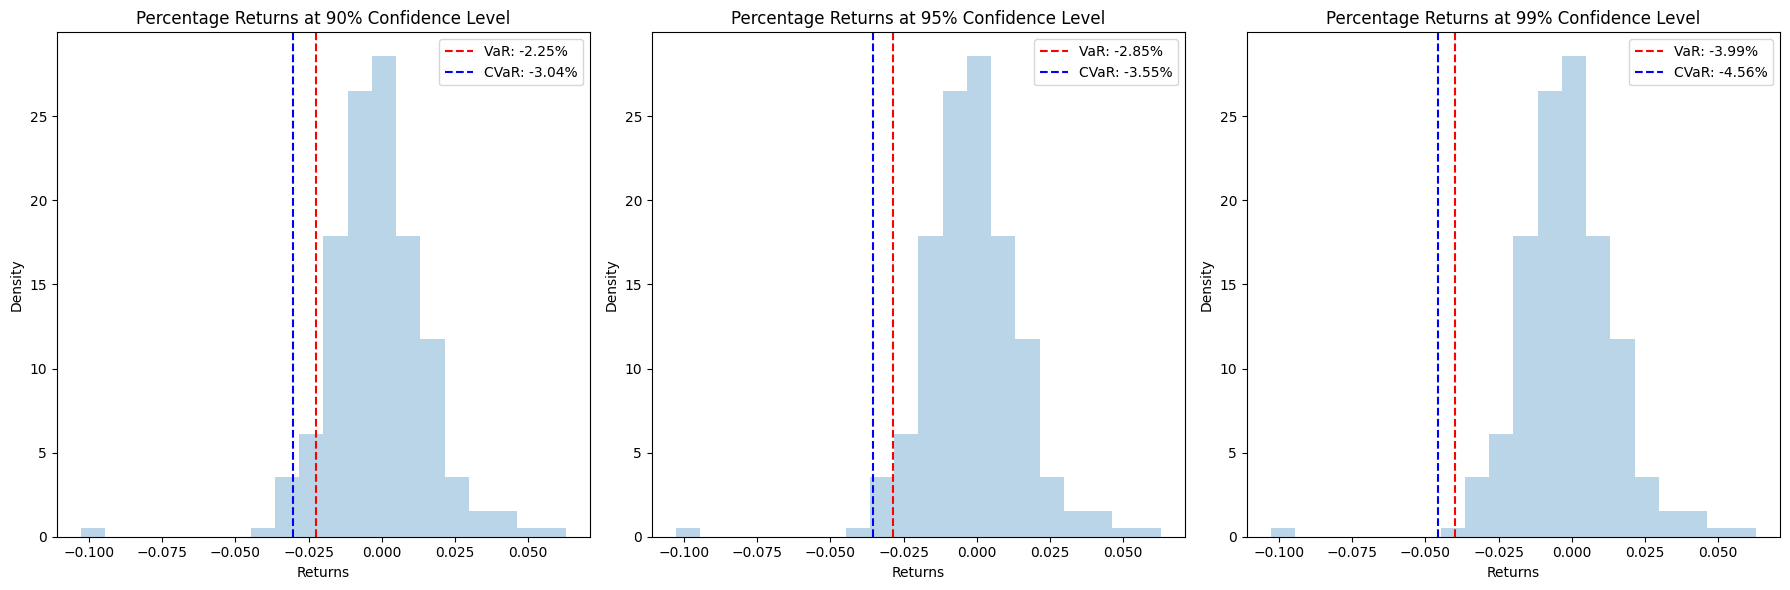

In [127]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Membuat 3 subplot dalam 1 baris

for idx, i in enumerate(confidence_level):
    ax = axes[idx]  # Pilih subplot berdasarkan indeks
    ax.hist(log_ret, bins=20, density=True, alpha=0.3)

    # Tambah VAR dan CVAR ke histogram
    ax.axvline(x=var[idx], color='red', linestyle='--', label=f"VaR: {var[idx]:.2%}")
    ax.axvline(x=cvar[idx], color='blue', linestyle='--', label=f"CVaR: {cvar[idx]:.2%}")

    ax.legend()
    ax.set_xlabel("Returns")
    ax.set_ylabel("Density")
    ax.set_title(f"Percentage Returns at {i*100:.0f}% Confidence Level")

# Optimalkan jarak antar subplot
plt.tight_layout()
plt.show()


In [128]:
import numpy as np
import pandas as pd
from scipy.stats import chi2

# Fungsi Kupiec Test
def kupiec_test(violations, total_obs, confidence_level):
    prob = 1 - confidence_level
    # Komponen LR_uc
    term_1 = -2 * ((total_obs - violations) * np.log(1 - prob) + violations * np.log(prob))
    term_2 = 2 * ((total_obs - violations) * np.log(1 - violations / total_obs) + violations * np.log(violations / total_obs))
    LR = term_1 + term_2
    chi2_critical = chi2.ppf(confidence_level, df=1)  # Nilai kritis Chi-square untuk alpha = 0.05
    return LR, chi2_critical

# Backtesting
lr_test_var = []
lr_test_cvar = []
chi_var = []
chi_cvar = []
violations_var_list = []
violations_cvar_list = []

# Perulangan berdasarkan DataFrame df_c_var
for index, row in df_c_var.iterrows():
    confidence_level = row['Confidence Level']
    var_value = row['VaR']
    cvar_value = row['CVaR']

    # Hitung jumlah pelanggaran (violations)
    violations_var = len(log_ret_sorted[log_ret_sorted <= var_value])
    violations_cvar = len(log_ret_sorted[log_ret_sorted <= cvar_value])
    total_obs = len(log_ret_sorted)

    # Simpan hasil ke dalam daftar
    violations_var_list.append(violations_var)
    violations_cvar_list.append(violations_cvar)

    # Hitung Kupiec Test untuk VaR
    lr_var, chi_var_value = kupiec_test(violations_var, total_obs, confidence_level)
    lr_test_var.append(lr_var)
    chi_var.append(chi_var_value)

    # Hitung Kupiec Test untuk CVaR
    lr_cvar, chi_cvar_value = kupiec_test(violations_cvar, total_obs, confidence_level)
    lr_test_cvar.append(lr_cvar)
    chi_cvar.append(chi_cvar_value)

# Membuat DataFrame hasil backtesting
df_backtest = pd.DataFrame({
    'Confidence Level': df_c_var['Confidence Level'],
    'VaR': df_c_var['VaR'],
    'CVaR': df_c_var['CVaR'],
    'Violations VaR': violations_var_list,
    'LR VaR': lr_test_var,
    'Chi-Square Var': chi_var,
    'Violations CVaR': violations_cvar_list,
    'LR CVaR': lr_test_cvar,
    'Chi-Square CVaR': chi_cvar
})

# Output hasil
df_backtest


,Confidence Level,VaR,CVaR,Violations VaR,LR VaR,Chi-Square Var,Violations CVaR,LR CVaR,Chi-Square CVaR
0,0.90,-0.022458,-0.030364,16,3.102317,2.705543,6,20.345168,2.705543
1,0.95,-0.028525,-0.035503,9,0.784065,3.841459,3,9.801104,3.841459
2,0.99,-0.039906,-0.045565,2,0.061612,6.634897,1,1.022204,6.634897


In [129]:
len(log_ret_sorted)

237

## Metode Monte Carlo

In [130]:
# Menetapkan random seed
np.random.seed(123)

n_simulation = 1000 # Jumlah simulasi yang dilakukan
T = 237 # Jumlah periode trading saham
mu = log_ret_sorted.mean() #mean return
sigma = log_ret_sorted.std() #standar deviasi return

In [131]:
sim_pct_change = np.full(shape=(T, n_simulation), fill_value=0.0)

# Simulasi Monte Carlo
for m in range(n_simulation):
    # Membangkitkan bilangan acak berdistribusi normal standar
    Z = np.random.normal(size=T)

    # Simulasi perubahan persentase harga saham harian
    daily_pct_change = mu + sigma * Z
    
    # Menyimpan hasil simulasi
    sim_pct_change[:, m] = daily_pct_change

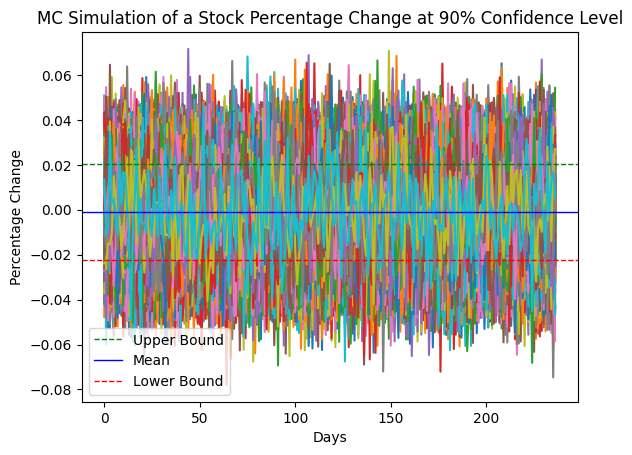

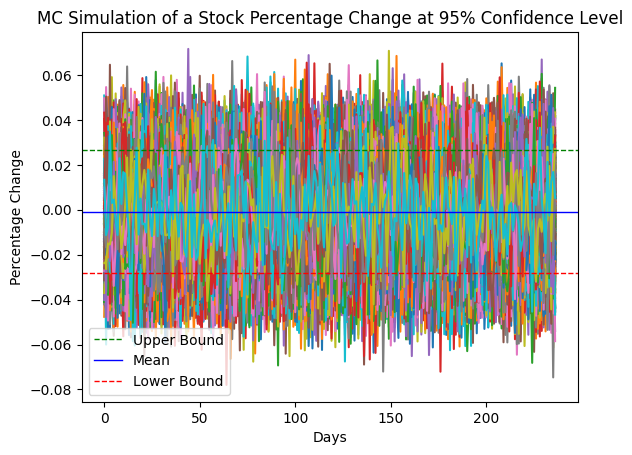

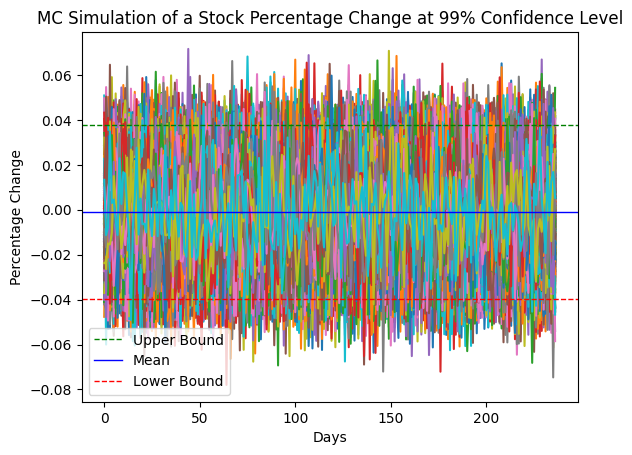

In [132]:
# Plotting
confidence_level = [0.90, 0.95, 0.99]
for idx, i in enumerate(confidence_level):
    plt.plot(sim_pct_change)

    plt.axhline(np.percentile(sim_pct_change,100*i), color='g', linestyle='dashed', linewidth=1,  label=f'Upper Bound')
    plt.axhline(np.mean(sim_pct_change), color='b', linestyle='solid', linewidth=1, label='Mean')
    plt.axhline(np.percentile(sim_pct_change,100*(1-i)), color='r', linestyle='dashed', linewidth=1, label=f'Lower Bound')

    plt.legend()
    plt.ylabel('Percentage Change')
    plt.xlabel('Days')
    plt.title(f'MC Simulation of a Stock Percentage Change at {i*100:.0f}% Confidence Level')
    plt.show()

In [133]:
confidence_level = [0.90, 0.95, 0.99]
var_list = []  # List untuk menyimpan VaR setiap simulasi
cvar_list = []  # List untuk menyimpan CVaR setiap simulasi

# Iterasi untuk setiap simulasi (kolom di sim_pct_change)
for sim in range(n_simulation):
    # Ambil satu simulasi (kolom ke-sim) dari hasil simulasi
    sim_returns = pd.Series(sim_pct_change[:, sim])  # Semua T hari dari satu simulasi
    
    # Tempat sementara untuk VaR dan CVaR pada confidence level yang berbeda
    var_sim = []
    cvar_sim = []
    
    # Hitung VaR dan CVaR untuk setiap confidence level
    for i in confidence_level:
        var_value = sim_returns.quantile(1 - i)  # Hitung VaR pada level confidence
        cvar_value = sim_returns[sim_returns <= var_value].mean()  # Hitung CVaR sebagai mean dari loss yang lebih besar dari VaR
        
        var_sim.append(var_value)
        cvar_sim.append(cvar_value)
    
    # Simpan hasil VaR dan CVaR untuk setiap simulasi
    var_list.append(var_sim)
    cvar_list.append(cvar_sim)

# Ambil rata-rata dari seluruh simulasi untuk setiap level confidence
var_mean = np.mean(var_list, axis=0)  # Rata-rata VaR untuk setiap confidence level
cvar_mean = np.mean(cvar_list, axis=0)  # Rata-rata CVaR untuk setiap confidence level

# Buat DataFrame untuk hasil akhir
df_c_var = pd.DataFrame({
    'Confidence Level': confidence_level,
    'VaR': var_mean,
    'CVaR': cvar_mean
})

df_c_var

,Confidence Level,VaR,CVaR
0,0.90,-0.022177,-0.029962
1,0.95,-0.028051,-0.034971
2,0.99,-0.038540,-0.043078


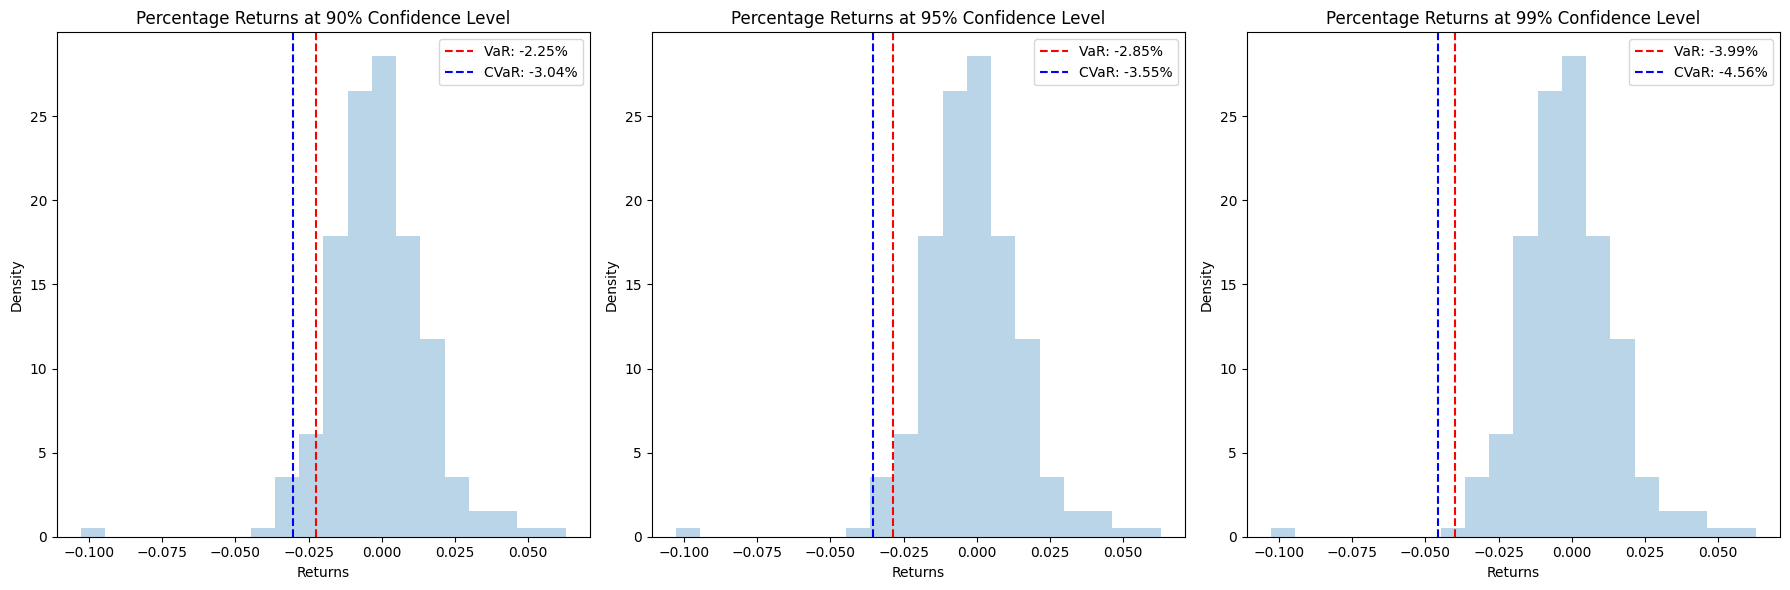

In [134]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Membuat 3 subplot dalam 1 baris

for idx, i in enumerate(confidence_level):
    ax = axes[idx]  # Pilih subplot berdasarkan indeks
    ax.hist(log_ret, bins=20, density=True, alpha=0.3)

    # Tambah VAR dan CVAR ke histogram
    ax.axvline(x=var[idx], color='red', linestyle='--', label=f"VaR: {var[idx]:.2%}")
    ax.axvline(x=cvar[idx], color='blue', linestyle='--', label=f"CVaR: {cvar[idx]:.2%}")

    ax.legend()
    ax.set_xlabel("Returns")
    ax.set_ylabel("Density")
    ax.set_title(f"Percentage Returns at {i*100:.0f}% Confidence Level")

# Optimalkan jarak antar subplot
plt.tight_layout()
plt.show()


In [135]:
import numpy as np
import pandas as pd
from scipy.stats import chi2

# Fungsi Kupiec Test
def kupiec_test(violations, total_obs, confidence_level):
    prob = 1 - confidence_level
    # Komponen LR_uc
    term_1 = -2 * ((total_obs - violations) * np.log(1 - prob) + violations * np.log(prob))
    term_2 = 2 * ((total_obs - violations) * np.log(1 - violations / total_obs) + violations * np.log(violations / total_obs))
    LR = term_1 + term_2
    chi2_critical = chi2.ppf(confidence_level, df=1)  # Nilai kritis Chi-square untuk alpha = 0.05
    return LR, chi2_critical

# Backtesting
lr_test_var = []
lr_test_cvar = []
chi_var = []
chi_cvar = []
violations_var_list = []
violations_cvar_list = []

# Perulangan berdasarkan DataFrame df_c_var
for index, row in df_c_var.iterrows():
    confidence_level = row['Confidence Level']
    var_value = row['VaR']
    cvar_value = row['CVaR']

    # Hitung jumlah pelanggaran (violations)
    violations_var = len(log_ret_sorted[log_ret_sorted <= var_value])
    violations_cvar = len(log_ret_sorted[log_ret_sorted <= cvar_value])
    total_obs = len(log_ret_sorted)

    # Simpan hasil ke dalam daftar
    violations_var_list.append(violations_var)
    violations_cvar_list.append(violations_cvar)

    # Hitung Kupiec Test untuk VaR
    lr_var, chi_var_value = kupiec_test(violations_var, total_obs, confidence_level)
    lr_test_var.append(lr_var)
    chi_var.append(chi_var_value)

    # Hitung Kupiec Test untuk CVaR
    lr_cvar, chi_cvar_value = kupiec_test(violations_cvar, total_obs, confidence_level)
    lr_test_cvar.append(lr_cvar)
    chi_cvar.append(chi_cvar_value)

# Membuat DataFrame hasil backtesting
df_backtest = pd.DataFrame({
    'Confidence Level': df_c_var['Confidence Level'],
    'VaR': df_c_var['VaR'],
    'CVaR': df_c_var['CVaR'],
    'Violations VaR': violations_var_list,
    'LR VaR': lr_test_var,
    'Chi-Square Var': chi_var,
    'Violations CVaR': violations_cvar_list,
    'LR CVaR': lr_test_cvar,
    'Chi-Square CVaR': chi_cvar
})

# Output hasil
df_backtest


,Confidence Level,VaR,CVaR,Violations VaR,LR VaR,Chi-Square Var,Violations CVaR,LR CVaR,Chi-Square CVaR
0,0.90,-0.022177,-0.029962,16,3.102317,2.705543,6,20.345168,2.705543
1,0.95,-0.028051,-0.034971,10,0.320304,3.841459,3,9.801104,3.841459
2,0.99,-0.038540,-0.043078,2,0.061612,6.634897,1,1.022204,6.634897
